In [1]:
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 5.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for out

In [2]:
import prophet

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.express as px

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

In [5]:
df = pd.read_csv('/content/dfIavg_A_Hourly.csv')
df.head()

Time     Iavg_A
0  2021-01-02 19:00:00  16.496783
1  2021-01-02 20:00:00  16.152183
2  2021-01-02 21:00:00  17.377550
3  2021-01-02 22:00:00  16.347800
4  2021-01-02 23:00:00  16.287483

In [6]:
len(df)

20401

In [7]:
df['Time'] = pd.to_datetime(df['Time'])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20401 entries, 0 to 20400
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    20401 non-null  datetime64[ns]
 1   Iavg_A  18272 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 318.9 KB


Time     Iavg_A
0 2021-01-02 19:00:00  16.496783
1 2021-01-02 20:00:00  16.152183
2 2021-01-02 21:00:00  17.377550
3 2021-01-02 22:00:00  16.347800
4 2021-01-02 23:00:00  16.287483

In [8]:
df = df.set_index('Time')
df

Iavg_A
Time                          
2021-01-02 19:00:00  16.496783
2021-01-02 20:00:00  16.152183
2021-01-02 21:00:00  17.377550
2021-01-02 22:00:00  16.347800
2021-01-02 23:00:00  16.287483
...                        ...
2023-05-02 15:00:00  47.339167
2023-05-02 16:00:00  45.313900
2023-05-02 17:00:00  25.722350
2023-05-02 18:00:00  17.685133
2023-05-02 19:00:00  16.467643

[20401 rows x 1 columns]

In [9]:
df['Iavg_A'].fillna(value=df['Iavg_A'].mean(), inplace=True)

In [10]:
fig = px.line(df.reset_index(), x ='Time', y='Iavg_A', title='Iavg_A')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector = dict(
        buttons = list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=1, label="2y", step="year", stepmode="backward"),
            dict(count=1, label="3y", step="year", stepmode="backward"),
            dict(step='all')
        ])
    )
)
fig.show()

In [11]:
df.isna().any()

Iavg_A    False
dtype: bool

In [12]:
import prophet

In [13]:
df_Iavg_A = df.reset_index()[['Time','Iavg_A']].rename({'Time':'ds','Iavg_A':'y'}, axis = 'columns')
df_Iavg_A

ds          y
0     2021-01-02 19:00:00  16.496783
1     2021-01-02 20:00:00  16.152183
2     2021-01-02 21:00:00  17.377550
3     2021-01-02 22:00:00  16.347800
4     2021-01-02 23:00:00  16.287483
...                   ...        ...
20396 2023-05-02 15:00:00  47.339167
20397 2023-05-02 16:00:00  45.313900
20398 2023-05-02 17:00:00  25.722350
20399 2023-05-02 18:00:00  17.685133
20400 2023-05-02 19:00:00  16.467643

[20401 rows x 2 columns]

In [14]:
train_size = int(len(df_Iavg_A) * 0.95)
test_size = len(df_Iavg_A) - train_size
train, test = df_Iavg_A.iloc[0:train_size], df_Iavg_A.iloc[train_size:len(df_Iavg_A)]
print(train.shape, test.shape)

(19380, 2) (1021, 2)


In [15]:
from prophet import Prophet

# Create a Prophet model with changepoint_range set to 0.95
m = Prophet(changepoint_range=0.95)


In [16]:
train

ds          y
0     2021-01-02 19:00:00  16.496783
1     2021-01-02 20:00:00  16.152183
2     2021-01-02 21:00:00  17.377550
3     2021-01-02 22:00:00  16.347800
4     2021-01-02 23:00:00  16.287483
...                   ...        ...
19375 2023-03-21 02:00:00  17.825933
19376 2023-03-21 03:00:00  17.217867
19377 2023-03-21 04:00:00  17.140917
19378 2023-03-21 05:00:00  17.326600
19379 2023-03-21 06:00:00  22.715533

[19380 rows x 2 columns]

In [17]:
m.fit(train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpggp1qa7f/e20eot5u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpggp1qa7f/81g8frkg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23152', 'data', 'file=/tmp/tmpggp1qa7f/e20eot5u.json', 'init=/tmp/tmpggp1qa7f/81g8frkg.json', 'output', 'file=/tmp/tmpggp1qa7f/prophet_modelm976znmd/prophet_model-20230525161140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:11:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:11:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [18]:
time_to_check = pd.to_datetime('2023-03-19 07:00:00')

if time_to_check in train['ds'].values:
    print("The time exists in the column.")
else:
    print("The time does not exist in the column.")

The time exists in the column.


In [19]:
future = m.make_future_dataframe(periods=1021, freq='H')
len(future)

20401

In [20]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
20396 2023-05-02 15:00:00  40.160143   27.713133   52.906231
20397 2023-05-02 16:00:00  35.661679   22.882024   47.703093
20398 2023-05-02 17:00:00  29.081380   16.861307   43.084059
20399 2023-05-02 18:00:00  23.084827   10.336928   36.512619
20400 2023-05-02 19:00:00  19.563619    7.738804   33.279745

In [21]:
# forecast

In [22]:
df_Iavg_A

ds          y
0     2021-01-02 19:00:00  16.496783
1     2021-01-02 20:00:00  16.152183
2     2021-01-02 21:00:00  17.377550
3     2021-01-02 22:00:00  16.347800
4     2021-01-02 23:00:00  16.287483
...                   ...        ...
20396 2023-05-02 15:00:00  47.339167
20397 2023-05-02 16:00:00  45.313900
20398 2023-05-02 17:00:00  25.722350
20399 2023-05-02 18:00:00  17.685133
20400 2023-05-02 19:00:00  16.467643

[20401 rows x 2 columns]

In [23]:
results = pd.concat([df_Iavg_A.set_index('ds')['y'],forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)

In [24]:
results

y       yhat  yhat_lower  yhat_upper
ds                                                               
2021-01-02 19:00:00  16.496783   5.596076   -7.183928   19.196311
2021-01-02 20:00:00  16.152183   4.305719   -8.567998   16.669241
2021-01-02 21:00:00  17.377550   4.195744   -9.199654   16.860780
2021-01-02 22:00:00  16.347800   4.064238   -9.976035   17.228092
2021-01-02 23:00:00  16.287483   3.691705   -9.048347   16.300719
...                        ...        ...         ...         ...
2023-05-02 15:00:00  47.339167  40.160143   27.713133   52.906231
2023-05-02 16:00:00  45.313900  35.661679   22.882024   47.703093
2023-05-02 17:00:00  25.722350  29.081380   16.861307   43.084059
2023-05-02 18:00:00  17.685133  23.084827   10.336928   36.512619
2023-05-02 19:00:00  16.467643  19.563619    7.738804   33.279745

[20401 rows x 4 columns]

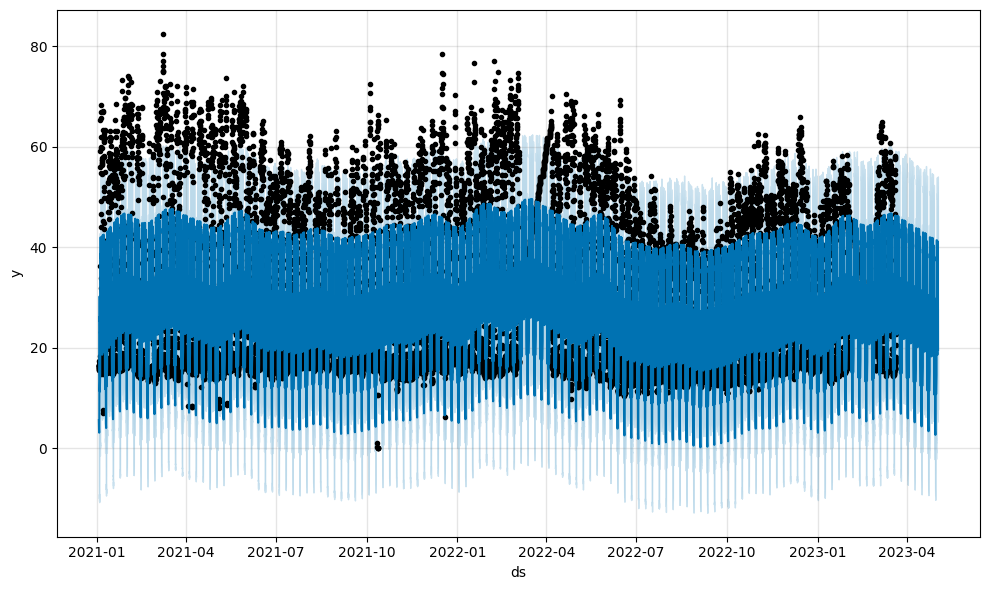

In [25]:
fig1 = m.plot(forecast)

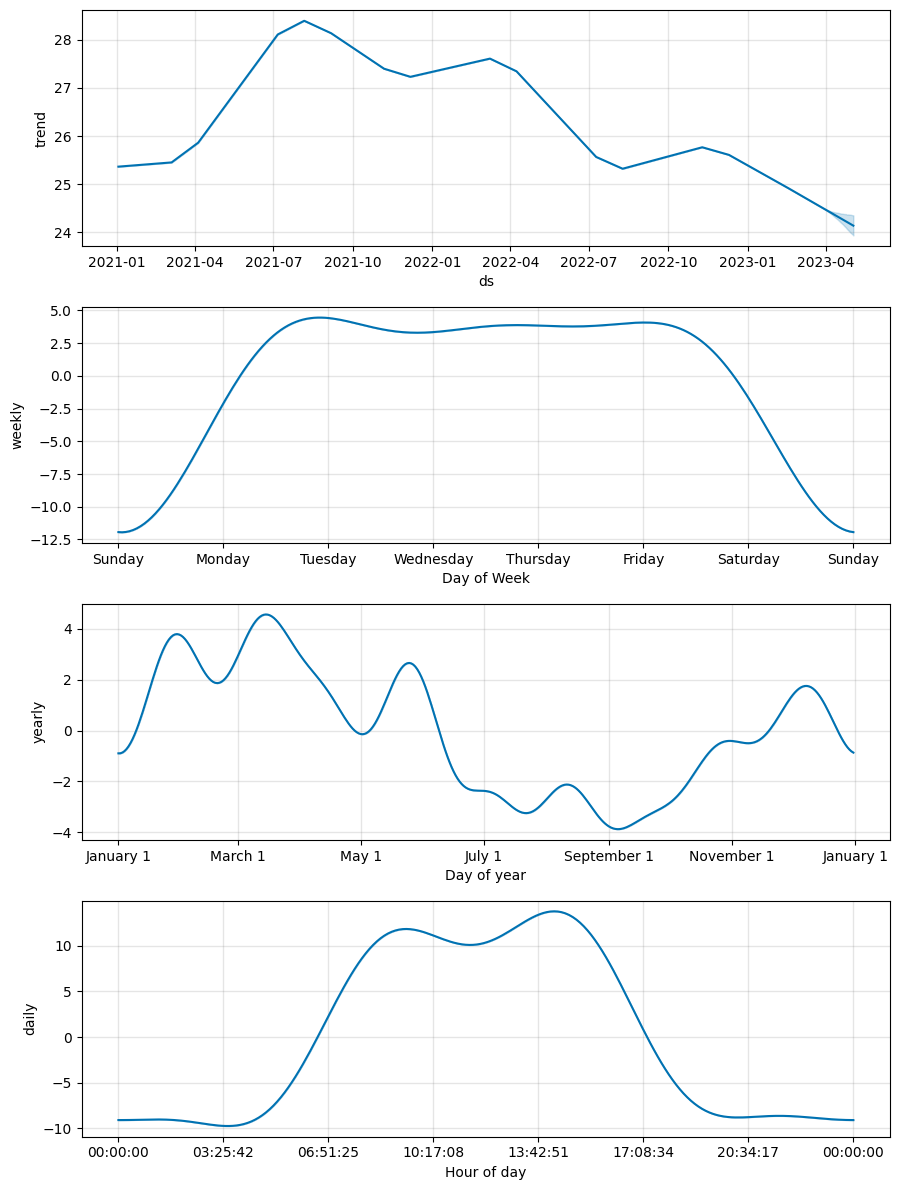

In [26]:
comp = m.plot_components(forecast)

In [27]:
results

y       yhat  yhat_lower  yhat_upper
ds                                                               
2021-01-02 19:00:00  16.496783   5.596076   -7.183928   19.196311
2021-01-02 20:00:00  16.152183   4.305719   -8.567998   16.669241
2021-01-02 21:00:00  17.377550   4.195744   -9.199654   16.860780
2021-01-02 22:00:00  16.347800   4.064238   -9.976035   17.228092
2021-01-02 23:00:00  16.287483   3.691705   -9.048347   16.300719
...                        ...        ...         ...         ...
2023-05-02 15:00:00  47.339167  40.160143   27.713133   52.906231
2023-05-02 16:00:00  45.313900  35.661679   22.882024   47.703093
2023-05-02 17:00:00  25.722350  29.081380   16.861307   43.084059
2023-05-02 18:00:00  17.685133  23.084827   10.336928   36.512619
2023-05-02 19:00:00  16.467643  19.563619    7.738804   33.279745

[20401 rows x 4 columns]

In [28]:
results['error'] = results['y'] - results['yhat']
results['uncertainty'] = results['yhat_upper'] - results['yhat_lower']
results

y       yhat  yhat_lower  yhat_upper      error  \
ds                                                                             
2021-01-02 19:00:00  16.496783   5.596076   -7.183928   19.196311  10.900707   
2021-01-02 20:00:00  16.152183   4.305719   -8.567998   16.669241  11.846465   
2021-01-02 21:00:00  17.377550   4.195744   -9.199654   16.860780  13.181806   
2021-01-02 22:00:00  16.347800   4.064238   -9.976035   17.228092  12.283562   
2021-01-02 23:00:00  16.287483   3.691705   -9.048347   16.300719  12.595778   
...                        ...        ...         ...         ...        ...   
2023-05-02 15:00:00  47.339167  40.160143   27.713133   52.906231   7.179023   
2023-05-02 16:00:00  45.313900  35.661679   22.882024   47.703093   9.652221   
2023-05-02 17:00:00  25.722350  29.081380   16.861307   43.084059  -3.359030   
2023-05-02 18:00:00  17.685133  23.084827   10.336928   36.512619  -5.399694   
2023-05-02 19:00:00  16.467643  19.563619    7.738804   33.279745  -3.095976   

                     uncertainty  
ds                                
2021-01-02 19:00:00    26.380239  
2021-01-02 20:00:00    25.237239  
2021-01-02 21:00:00    26.060434  
2021-01-02 22:00:00    27.204127  
2021-01-02 23:00:00    25.349066  
...                          ...  
2023-05-02 15:00:00    25.193099  
2023-05-02 16:00:00    24.821069  
2023-05-02 17:00:00    26.222752  
2023-05-02 18:00:00    26.175692  
2023-05-02 19:00:00    25.540941  

[20401 rows x 6 columns]

In [29]:
results[results['error'].abs() > 1.5*results['uncertainty']]

y       yhat  yhat_lower  yhat_upper      error  \
ds                                                                             
2021-03-08 10:00:00  82.456917  43.710341   31.507289   56.600286  38.746575   
2021-04-02 14:00:00   8.447600  44.781434   33.170131   57.132770 -36.333834   

                     uncertainty  
ds                                
2021-03-08 10:00:00    25.092998  
2021-04-02 14:00:00    23.962640

In [30]:
len(results[results['error'].abs() > 1.5*results['uncertainty']])

2

In [31]:
results['anomaly'] = results.apply(lambda x: 'Yes' if(np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis=1)

In [32]:
results

y       yhat  yhat_lower  yhat_upper      error  \
ds                                                                             
2021-01-02 19:00:00  16.496783   5.596076   -7.183928   19.196311  10.900707   
2021-01-02 20:00:00  16.152183   4.305719   -8.567998   16.669241  11.846465   
2021-01-02 21:00:00  17.377550   4.195744   -9.199654   16.860780  13.181806   
2021-01-02 22:00:00  16.347800   4.064238   -9.976035   17.228092  12.283562   
2021-01-02 23:00:00  16.287483   3.691705   -9.048347   16.300719  12.595778   
...                        ...        ...         ...         ...        ...   
2023-05-02 15:00:00  47.339167  40.160143   27.713133   52.906231   7.179023   
2023-05-02 16:00:00  45.313900  35.661679   22.882024   47.703093   9.652221   
2023-05-02 17:00:00  25.722350  29.081380   16.861307   43.084059  -3.359030   
2023-05-02 18:00:00  17.685133  23.084827   10.336928   36.512619  -5.399694   
2023-05-02 19:00:00  16.467643  19.563619    7.738804   33.279745  -3.095976   

                     uncertainty anomaly  
ds                                        
2021-01-02 19:00:00    26.380239      No  
2021-01-02 20:00:00    25.237239      No  
2021-01-02 21:00:00    26.060434      No  
2021-01-02 22:00:00    27.204127      No  
2021-01-02 23:00:00    25.349066      No  
...                          ...     ...  
2023-05-02 15:00:00    25.193099      No  
2023-05-02 16:00:00    24.821069      No  
2023-05-02 17:00:00    26.222752      No  
2023-05-02 18:00:00    26.175692      No  
2023-05-02 19:00:00    25.540941      No  

[20401 rows x 7 columns]

In [33]:
import plotly.express as px

def plot_anomaly_scatter(df):
    fig = px.scatter(df.reset_index(), x='ds', y='y', color='anomaly', title='Iavg_A')

    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(count=2, label="2y", step="year", stepmode="backward"),
                dict(count=3, label="3y", step="year", stepmode="backward"),
                dict(step='all')
            ])
        )
    )
    
    fig.show()


In [34]:
fig = px.scatter(results.reset_index(), x='ds',y='y', color='anomaly', title='Iavg_A')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector = dict(
        buttons = list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=1, label="2y", step="year", stepmode="backward"),
            dict(count=1, label="3y", step="year", stepmode="backward"),
            dict(step='all')
        ])
    )
)
fig.show()

Z-score Threshold

In [35]:
# # Calculate the mean and standard deviation of the 'error' column
# mean_error = results['error'].mean()
# std_error = results['error'].std()

# # Calculate the z-scores
# results['z_score'] = (results['error'] - mean_error) / std_error

# # Set the threshold for outliers (e.g., z-score > 2)
# threshold = 2

# # Filter the outliers based on the z-scores
# outliers = results[results['z_score'].abs() > threshold]

# outliers





import numpy as np

results['error'] = results['y'] - results['yhat']
results['uncertainty'] = results['yhat_upper'] - results['yhat_lower']

# Calculate the Z-score for each data point
results['z_score'] = (results['error'] - results['error'].mean()) / results['error'].std()

# Set the Z-score threshold (e.g., 2.5 or 3)
z_score_threshold = 2.5

# Detect outliers based on the Z-score threshold
results['anomaly'] = np.where(results['z_score'].abs() > z_score_threshold, 'Yes', 'No')

# Print the results
results




y       yhat  yhat_lower  yhat_upper      error  \
ds                                                                             
2021-01-02 19:00:00  16.496783   5.596076   -7.183928   19.196311  10.900707   
2021-01-02 20:00:00  16.152183   4.305719   -8.567998   16.669241  11.846465   
2021-01-02 21:00:00  17.377550   4.195744   -9.199654   16.860780  13.181806   
2021-01-02 22:00:00  16.347800   4.064238   -9.976035   17.228092  12.283562   
2021-01-02 23:00:00  16.287483   3.691705   -9.048347   16.300719  12.595778   
...                        ...        ...         ...         ...        ...   
2023-05-02 15:00:00  47.339167  40.160143   27.713133   52.906231   7.179023   
2023-05-02 16:00:00  45.313900  35.661679   22.882024   47.703093   9.652221   
2023-05-02 17:00:00  25.722350  29.081380   16.861307   43.084059  -3.359030   
2023-05-02 18:00:00  17.685133  23.084827   10.336928   36.512619  -5.399694   
2023-05-02 19:00:00  16.467643  19.563619    7.738804   33.279745  -3.095976   

                     uncertainty anomaly   z_score  
ds                                                  
2021-01-02 19:00:00    26.380239      No  1.089059  
2021-01-02 20:00:00    25.237239      No  1.183883  
2021-01-02 21:00:00    26.060434      No  1.317767  
2021-01-02 22:00:00    27.204127      No  1.227707  
2021-01-02 23:00:00    25.349066      No  1.259010  
...                          ...     ...       ...  
2023-05-02 15:00:00    25.193099      No  0.715916  
2023-05-02 16:00:00    24.821069      No  0.963884  
2023-05-02 17:00:00    26.222752      No -0.340650  
2023-05-02 18:00:00    26.175692      No -0.545251  
2023-05-02 19:00:00    25.540941      No -0.314276  

[20401 rows x 8 columns]

In [36]:
plot_anomaly_scatter(results)

Modified Z-Score

In [37]:
# from scipy.stats import median_absolute_deviation

# # Calculate the median and median absolute deviation (MAD) of the 'error' column
# median_error = results['error'].median()
# mad_error = median_absolute_deviation(results['error'])

# # Calculate the modified z-scores
# results['modified_z_score'] = 0.6745 * (results['error'] - median_error) / mad_error

# # Set the threshold for outliers (e.g., modified z-score > 3.5)
# threshold = 3.5

# # Filter the outliers based on the modified z-scores
# outliers = results[results['modified_z_score'].abs() > threshold]

# # Display the outliers
# print(outliers)



import numpy as np

results['error'] = results['y'] - results['yhat']
results['uncertainty'] = results['yhat_upper'] - results['yhat_lower']

# Calculate the Median Absolute Deviation (MAD)
median_abs_deviation = np.median(np.abs(results['error'] - results['error'].median()))

# Calculate the Modified Z-Score for each data point
results['modified_z_score'] = 0.6745 * (results['error'] - results['error'].median()) / median_abs_deviation

# Set the Modified Z-Score threshold (e.g., 3 or 3.5)
modified_z_score_threshold = 3

# Detect outliers based on the Modified Z-Score threshold
results['anomaly'] = np.where(results['modified_z_score'].abs() > modified_z_score_threshold, 'Yes', 'No')

len(results[results['anomaly']=='Yes'])


96

In [38]:
plot_anomaly_scatter(results)

Tukey's fences

In [39]:
# # Calculate the first quartile (Q1), third quartile (Q3), and interquartile range (IQR) of the 'error' column
# Q1 = results['error'].quantile(0.25)
# Q3 = results['error'].quantile(0.75)
# IQR = Q3 - Q1

# # Set the parameter for Tukey's fences (e.g., k = 1.5)
# k = 1.5

# # Calculate the lower and upper fences
# lower_fence = Q1 - k * IQR
# upper_fence = Q3 + k * IQR

# # Filter the outliers based on the fences
# outliers = results[(results['error'] < lower_fence) | (results['error'] > upper_fence)]

# # Display the outliers
# print(outliers)


import numpy as np

results['error'] = results['y'] - results['yhat']
results['uncertainty'] = results['yhat_upper'] - results['yhat_lower']

# Calculate the interquartile range (IQR)
Q1 = results['error'].quantile(0.25)
Q3 = results['error'].quantile(0.75)
IQR = Q3 - Q1

# Set the Tukey's fence threshold (e.g., 1.5)
tukey_fence_threshold = 1.5

# Define the lower and upper fences
lower_fence = Q1 - tukey_fence_threshold * IQR
upper_fence = Q3 + tukey_fence_threshold * IQR

# Detect outliers based on Tukey's fences
results['anomaly'] = np.where((results['error'] < lower_fence) | (results['error'] > upper_fence), 'Yes', 'No')

len(results[results['anomaly']=='Yes'])



261

In [40]:
plot_anomaly_scatter(results)

Outlier detection algorithms

1. Isolation Forest

In [41]:
# from sklearn.ensemble import IsolationForest

# # Create the Isolation Forest model
# model = IsolationForest(contamination=0.05)  # Set the contamination parameter to the expected outlier proportion

# # Fit the model on the 'error' column
# model.fit(results[['error']])

# # Predict the outliers
# outliers = model.predict(results[['error']])

# # Filter the rows where outliers are detected
# outliers_df = results[outliers == -1]

# # Display the outliers
# print(outliers_df)



from sklearn.ensemble import IsolationForest

results['error'] = results['y'] - results['yhat']
results['uncertainty'] = results['yhat_upper'] - results['yhat_lower']

# Create an Isolation Forest model
model = IsolationForest(contamination=0.05)  # Adjust the contamination parameter as needed

# Fit the model to the error values
model.fit(results[['error']])

# Predict the outliers
results['anomaly'] = np.where(model.predict(results[['error']]) == -1, 'Yes', 'No')

len(results[results['anomaly']=='Yes'])


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



1020

In [42]:
plot_anomaly_scatter(results)

2. One-Class SVM

In [43]:
# from sklearn.svm import OneClassSVM

# # Create the One-Class SVM model
# model = OneClassSVM(nu=0.05)  # Set the 'nu' parameter to the expected outlier proportion

# # Fit the model on the 'error' column
# model.fit(results[['error']])

# # Predict the outliers
# outliers = model.predict(results[['error']])

# # Filter the rows where outliers are detected
# outliers_df = results[outliers == -1]


from sklearn.svm import OneClassSVM

results['error'] = results['y'] - results['yhat']
results['uncertainty'] = results['yhat_upper'] - results['yhat_lower']

# Create a One-Class SVM model
model = OneClassSVM(nu=0.05)  # Adjust the nu parameter as needed

# Fit the model to the error values
model.fit(results[['error']])

# Predict the outliers
results['anomaly'] = np.where(model.predict(results[['error']]) == -1, 'Yes', 'No')
print(len(results[results['anomaly']=='Yes']))


plot_anomaly_scatter(results)

996


3.  Local Outlier Factor (LOF)

In [ ]:
# from sklearn.neighbors import LocalOutlierFactor

# # Create the LOF model
# model = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # Set the number of neighbors and contamination

# # Fit the model on the 'error' column
# model.fit(results[['error']])

# # Compute the outlier scores
# scores = model.negative_outlier_factor_

# # Predict the outliers
# outliers = model.predict(results[['error']])

# # Filter the rows where outliers are detected
# outliers_df = results[outliers == -1]

# # Display the outliers
# print(outliers_df)


from sklearn.neighbors import LocalOutlierFactor

results['error'] = results['y'] - results['yhat']
results['uncertainty'] = results['yhat_upper'] - results['yhat_lower']

# Create a Local Outlier Factor model
model = LocalOutlierFactor(contamination=0.05, novelty=False)  # Adjust the contamination parameter as needed

# Fit the model to the error values and predict outliers
results['anomaly1'] = model.fit_predict(results[['error']])
results['anomaly'] = np.where(results['anomaly1'] == -1, 'Yes', 'No')

# Print the results
print(results)


print(len(results[results['anomaly']=='Yes']))

plot_anomaly_scatter(results)

                              y        yhat  yhat_lower  yhat_upper     error  \
ds                                                                              
2021-01-02 19:00:00  240.609217  243.150117  237.503930  249.021678 -2.540899   
2021-01-02 20:00:00  242.816783  243.731181  238.028244  249.152530 -0.914397   
2021-01-02 21:00:00  241.642667  243.792493  238.284319  249.886421 -2.149826   
2021-01-02 22:00:00  242.809217  243.584820  238.417552  249.643108 -0.775603   
2021-01-02 23:00:00  241.877150  243.318529  237.541303  249.104046 -1.441379   
...                         ...         ...         ...         ...       ...   
2023-05-02 15:00:00  235.497283  234.227101  227.369086  240.568069  1.270183   
2023-05-02 16:00:00  233.516883  234.679347  228.000851  241.156264 -1.162464   
2023-05-02 17:00:00  236.922617  235.765849  229.185340  242.074622  1.156768   
2023-05-02 18:00:00  236.840750  237.080361  230.257851  244.090968 -0.239611   
2023-05-02 19:00:00  238.569